In [1]:
from myenv.models.candlestick import Candlestick
from myenv.models.merchandise_rate import MerchandiseRate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


merchandise_rate = MerchandiseRate()
merchandise_rate_id = merchandise_rate.find_by_slug('BTCUSDT')
candlestick = Candlestick(merchandise_rate_id)


bitcoin_prices = candlestick.to_df()

bitcoin_prices.describe()

bitcoin_prices['day_name'] = bitcoin_prices[['open']].apply(
    lambda x: x.name.strftime("%A"), axis=1)

print(bitcoin_prices)

total = bitcoin_prices.iloc[:,0].count()
first_date = bitcoin_prices.iloc[0].name.date()
last_date = bitcoin_prices.iloc[-1].name.date()



                               open      high     close       low   day_name
date                                                                        
2017-08-17 07:00:00+07:00   4261.48   4485.39   4285.08   4200.74   Thursday
2017-08-18 07:00:00+07:00   4285.08   4371.52   4108.37   3938.77     Friday
2017-08-19 07:00:00+07:00   4108.37   4184.69   4139.98   3850.00   Saturday
2017-08-20 07:00:00+07:00   4120.98   4211.08   4086.29   4032.62     Sunday
2017-08-21 07:00:00+07:00   4069.13   4119.62   4016.00   3911.79     Monday
...                             ...       ...       ...       ...        ...
2021-09-22 07:00:00+07:00  40734.10  44000.60  43543.60  40565.40  Wednesday
2021-09-23 07:00:00+07:00  43546.40  44978.00  44865.30  43069.10   Thursday
2021-09-24 07:00:00+07:00  44865.30  45200.00  42810.60  40675.00     Friday
2021-09-25 07:00:00+07:00  42810.60  42966.80  42670.60  41646.30   Saturday
2021-09-26 07:00:00+07:00  42670.60  42735.10  41381.40  40750.00     Sunday

# GIAO DỊCH TRONG BIÊN ĐỘ


<Figure size 432x288 with 0 Axes>

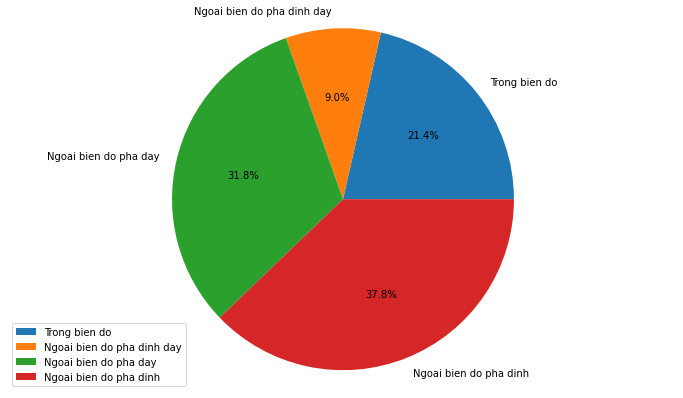

Đối với tập dự liệu giá BTC từ 2017-08-17 đến 2021-09-26, xác suất của việc mức giá cao nhất bị phá vỡ là 46.8%, mức giá thấp nhất bị phá vỡ là 40.7% và cả hai đỉnh đáy bị phá vỡ là 9.0%.
Có ít hơn 21.4% số ngày là những ngày giao dịch trong biên độ


In [2]:
data = [0]

for index in range(0, total):
    if index < 1:
        continue
    
    # trong biên độ
    inside_bar_type = 0
    current_row = bitcoin_prices.iloc[index]
    previous_row = bitcoin_prices.iloc[index - 1]

    if current_row['low'] < previous_row['low'] and current_row['high'] > previous_row['high']:
        # Ngoài biên độ phá vỡ đỉnh và dáy
        inside_bar_type = 1
    elif current_row['low'] < previous_row['low']:
        # Ngoài biên độ phá vỡ dáy
        inside_bar_type = 2
    elif current_row['high'] > previous_row['high']:
        # Ngoài biên độ phá vỡ đỉnh
        inside_bar_type = 3

    data.append(inside_bar_type)

bitcoin_prices['inside_bar_type'] = data

group_inside_bar_type = bitcoin_prices.groupby(
    'inside_bar_type').inside_bar_type.count()

labels = 'Trong bien do', 'Ngoai bien do pha dinh day', 'Ngoai bien do pha day', 'Ngoai bien do pha dinh'
sizes = [group_inside_bar_type.loc[0],
         group_inside_bar_type.loc[1], group_inside_bar_type.loc[2], group_inside_bar_type.loc[3]]

plt.figure()
fig1, ax1 = plt.subplots(figsize=(12, 7))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.legend()
plt.show()

probability_break_high = '{:.1%}'.format((group_inside_bar_type.loc[3] +
                                          group_inside_bar_type.loc[1])/total)
probability_break_low = '{:.1%}'.format((group_inside_bar_type.loc[2] +
                                         group_inside_bar_type.loc[1])/total)
probability_break_both = '{:.1%}'.format(group_inside_bar_type.loc[1]/total)
probability_inside_day = '{:.1%}'.format(group_inside_bar_type.loc[0]/total)

print(
    f"Đối với tập dự liệu giá BTC từ {first_date} đến {last_date}, xác suất của việc mức giá cao nhất bị phá vỡ là {probability_break_high}, mức giá thấp nhất bị phá vỡ là {probability_break_low} và cả hai đỉnh đáy bị phá vỡ là {probability_break_both}.")
print(
    f"Có ít hơn {probability_inside_day} số ngày là những ngày giao dịch trong biên độ")


# HIỆU ỨNG NGÀY TRONG TUẦN VÀ HÀNH VI THỊ TRƯỜNG

In [3]:
import datetime

candlestick_week = Candlestick(merchandise_rate_id, interval="week")

bitcoin_prices_week = candlestick_week.to_df()

bitcoin_prices_week.describe()

bitcoin_prices_week['end_week'] = bitcoin_prices_week[['high']].apply(
    lambda x: x.name.date() + datetime.timedelta(days=6), axis=1)

total_week = bitcoin_prices_week.iloc[:,1].count()
print(total_week)

def min_low_in_week(x):
    df_week = bitcoin_prices[x.name.strftime("%Y-%m-%d"):x['end_week'].strftime("%Y-%m-%d")]
    return df_week[df_week.low == df_week.low.min()].iloc[0, 4]

def max_high_in_week(x):
    df_week = bitcoin_prices[x.name.strftime(
        "%Y-%m-%d"):x['end_week'].strftime("%Y-%m-%d")]
    return df_week[df_week.high == df_week.high.max()].iloc[0, 4]

bitcoin_prices_week['min_low_in_week'] = bitcoin_prices_week[[
    'end_week']].apply(lambda x: min_low_in_week(x), axis=1)

bitcoin_prices_week['max_high_in_week'] = bitcoin_prices_week[[
    'end_week']].apply(lambda x: max_high_in_week(x), axis=1)

group_min_low_in_week = bitcoin_prices_week.groupby(
    'min_low_in_week').min_low_in_week.count()

group_max_high_in_week = bitcoin_prices_week.groupby(
    'max_high_in_week').max_high_in_week.count()

print(group_min_low_in_week)
print(group_max_high_in_week)


214
min_low_in_week
Friday       23
Monday       74
Saturday      9
Sunday       29
Thursday     29
Tuesday      29
Wednesday    21
Name: min_low_in_week, dtype: int64
max_high_in_week
Friday       19
Monday       61
Saturday     32
Sunday       42
Thursday     16
Tuesday      22
Wednesday    22
Name: max_high_in_week, dtype: int64


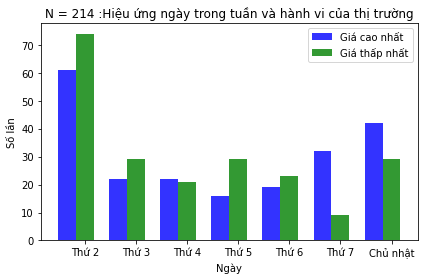

Đối với tập dự liệu giá BTC từ 2017-08-17 đến 2021-09-26, Thứ hai là ngày giao dịch biến động nhất tuần:
- 28.5% các ngày thứ hai đã thiết lập mức giá cao nhất tuần
- 34.6% các ngày thứ hai đã thiết lập mức giá thấp nhất tuần
Trong số 214 tuần của bộ dữ liệu này, ngày thứ hai thiết lập mức giá cao nhất hoặc thấp nhất là 135 lần, tức là chiếm 31.5%
Có 2 ngày thứ hai vừa thiêt lập cả mức giá cao nhất và thâp nhất trong tuần.


In [4]:
n_groups = 7
min_low_in_week = (
    group_min_low_in_week['Monday'],
    group_min_low_in_week['Tuesday'],
    group_min_low_in_week['Wednesday'],
    group_min_low_in_week['Thursday'],
    group_min_low_in_week['Friday'],
    group_min_low_in_week['Saturday'],
    group_min_low_in_week['Sunday']
)
max_high_in_week = (
    group_max_high_in_week['Monday'],
    group_max_high_in_week['Tuesday'],
    group_max_high_in_week['Wednesday'],
    group_max_high_in_week['Thursday'],
    group_max_high_in_week['Friday'],
    group_max_high_in_week['Saturday'],
    group_max_high_in_week['Sunday']
)
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, max_high_in_week, bar_width,
                 alpha=opacity, color='b', label='Giá cao nhất')

rects2 = plt.bar(index + bar_width, min_low_in_week, bar_width,
                 alpha=opacity, color='g', label='Giá thấp nhất')

plt.xlabel('Ngày')
plt.ylabel('Số lần')
plt.title(
    f"N = {total_week} :Hiệu ứng ngày trong tuần và hành vi của thị trường")
plt.xticks(index + bar_width, ('Thứ 2', 'Thứ 3',
                               'Thứ 4', 'Thứ 5', 'Thứ 6', 'Thứ 7', 'Chủ nhật'))
plt.legend()
plt.tight_layout()
plt.show()

monday_high_low_prices = bitcoin_prices_week[(bitcoin_prices_week.min_low_in_week == 'Monday') & (
    bitcoin_prices_week.max_high_in_week == 'Monday')]

probability_monday_establish_high = '{:.1%}'.format(
    group_max_high_in_week['Monday']/total_week)
probability_monday_establish_low = '{:.1%}'.format(
    group_min_low_in_week['Monday']/total_week)
probability_monday_establish_high_or_low = '{:.1%}'.format(
    (group_min_low_in_week['Monday'] + group_max_high_in_week['Monday'])/(2*total_week))

print(
    f"Đối với tập dự liệu giá BTC từ {first_date} đến {last_date}, Thứ hai là ngày giao dịch biến động nhất tuần:")
print(f"- {probability_monday_establish_high} các ngày thứ hai đã thiết lập mức giá cao nhất tuần")
print(f"- {probability_monday_establish_low} các ngày thứ hai đã thiết lập mức giá thấp nhất tuần")
print(
    f"Trong số {total_week} tuần của bộ dữ liệu này, ngày thứ hai thiết lập mức giá cao nhất hoặc thấp nhất là {group_max_high_in_week['Monday'] + group_min_low_in_week['Monday']} lần, tức là chiếm {probability_monday_establish_high_or_low}")
print(f"Có {monday_high_low_prices.iloc[:,0].count()} ngày thứ hai vừa thiêt lập cả mức giá cao nhất và thâp nhất trong tuần.")


### Câu hỏi
Nếu ngày thứ hai là ngày thiết lập mức giá thấp nhất hoặc cao nhất của tuần thì ngày nào điều kiện nghịch đảo dễ xảy ra nhất?

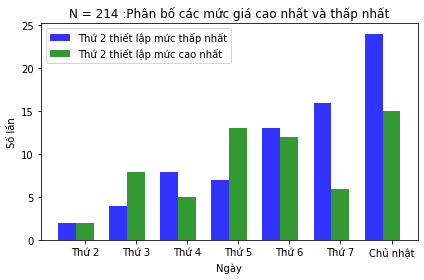

In [6]:
monday_lowest_prices = bitcoin_prices_week[(
    bitcoin_prices_week.min_low_in_week == 'Monday')]

group_monday_lowest_prices = monday_lowest_prices.groupby(
    'max_high_in_week').max_high_in_week.count()

monday_highest_prices = bitcoin_prices_week[(
    bitcoin_prices_week.max_high_in_week == 'Monday')]

group_monday_highest_prices = monday_highest_prices.groupby(
    'min_low_in_week').min_low_in_week.count()


n_groups = 7
monday_min_low_in_week = (
    group_monday_lowest_prices['Monday'],
    group_monday_lowest_prices['Tuesday'],
    group_monday_lowest_prices['Wednesday'],
    group_monday_lowest_prices['Thursday'],
    group_monday_lowest_prices['Friday'],
    group_monday_lowest_prices['Saturday'],
    group_monday_lowest_prices['Sunday']
)
monday_max_high_in_week = (
    group_monday_highest_prices['Monday'],
    group_monday_highest_prices['Tuesday'],
    group_monday_highest_prices['Wednesday'],
    group_monday_highest_prices['Thursday'],
    group_monday_highest_prices['Friday'],
    group_monday_highest_prices['Saturday'],
    group_monday_highest_prices['Sunday']
)
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, monday_min_low_in_week, bar_width,
                 alpha=opacity, color='b', label='Thứ 2 thiết lập mức thấp nhất')

rects2 = plt.bar(index + bar_width, monday_max_high_in_week, bar_width,
                 alpha=opacity, color='g', label='Thứ 2 thiết lập mức cao nhất')

plt.xlabel('Ngày')
plt.ylabel('Số lần')
plt.title(
    f"N = {total_week} :Phân bố các mức giá cao nhất và thấp nhất")
plt.xticks(index + bar_width, ('Thứ 2', 'Thứ 3',
                               'Thứ 4', 'Thứ 5', 'Thứ 6', 'Thứ 7', 'Chủ nhật'))
plt.legend()
plt.tight_layout()
plt.show()


In [128]:
print(group_monday_lowest_prices)


max_high_in_week
Friday       13
Monday        2
Saturday     14
Sunday       23
Thursday      7
Tuesday       4
Wednesday     8
Name: max_high_in_week, dtype: int64


### KẾT LUẬN
Nếu mua vào ngày thứ hai trong xu hướng giảm giá, chúng ta sẽ dễ mua được giá thấp nhất trong tuần. Khi đã mua ở ngày thứ 2 và nó đang thiết lập mức giá thấp nhất trong tuần thì ta nên bán ra vào ngày chủ nhật để có được lợi nhuận cao nhất.